### Model

A 2 layer transformer with 2 head in each attention layer was used. Here, the model performed best with a dropout of 0.3 and a learning rate of 1e-12. Early stopping was employed during training.

The model was trained both with and without stop-word removal

### Results

The model performed better when stop words were removed causing an approximately 20% increase in accuracy. The highest accuracy achieved is roughly 62%. Based on the training and validation plots, the model seems to be have the ability to learn more but its accuracy does not go above 61% despite changing hyperparameters such as number of layers, heads, learning rate, etc. This could be because the model requires a lot more data to develop an understanding of the intricacies between the two labels. This could also be due to issues with the dataset such as the data being improperly labelled. This is briefly explained in the article [Low accuracy of Transformer model for 1D Data](https://stackoverflow.com/questions/67755365/low-accuracy-of-transformer-model-for-1d-data).

Resources Used:

*   [Writing a Transformer Classifier in PyTorch](https://n8henrie.com/2021/08/writing-a-transformer-classifier-in-pytorch/)
*   [LANGUAGE MODELING WITH NN.TRANSFORMER AND TORCHTEXT](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model)



## Imports

In [1]:
# !pip install torchtext==0.6.0

In [2]:
import math
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings

import torch
import torch.nn as nn
import torchtext
from torchtext.data import Field, TabularDataset
from torchtext.vocab import Vectors
import torch.nn.functional as F
from torch import nn, optim

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Definitions

In [3]:
batch_size = 16
vocab_size = 3097

PATH = "/content/drive/MyDrive/Class Stuff/Fall23/NLP/Final Project/Data"
train_path = os.path.join(PATH,"train.csv")
val_path = os.path.join(PATH,"val.csv")
test_path = os.path.join(PATH,"test.csv")

## Data Loaders

In [4]:
TEXT = Field(sequential=True, lower=True, include_lengths=False, batch_first=True)
LABEL = Field(sequential=False, use_vocab=False)

fields = [('sentence', TEXT), ('label', LABEL)]

In [5]:
train_data = TabularDataset(
    path=train_path,
    format="csv",
    fields=fields,
    skip_header=True
)

val_data = TabularDataset(
    path=val_path,
    format="csv",
    fields=fields,
    skip_header=True
)

test_data = TabularDataset(
    path=test_path,
    format="csv",
    fields=fields,
    skip_header=True
)

In [6]:
glove_vectors = torchtext.vocab.GloVe(name="6B", dim=50, max_vectors=50_000)

In [7]:
TEXT.build_vocab(train_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(train_data)

TEXT.build_vocab(val_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(val_data)

TEXT.build_vocab(test_data, vectors=glove_vectors, max_size=50000)
LABEL.build_vocab(test_data)

In [8]:
train_iter = torchtext.data.BucketIterator(
    dataset=train_data,
    batch_size=batch_size
)

val_iter = torchtext.data.BucketIterator(
    dataset=val_data,
    batch_size=batch_size
)

test_iter = torchtext.data.BucketIterator(
    dataset=test_data,
    batch_size=batch_size
)

In [9]:
N_train = 0
N_val = 0
N_test = 0
for x,y in train_iter:
  N_train+=len(x[0])
for x,y in val_iter:
    N_val+=len(x[0])
for x,y in test_iter:
    N_test+=len(x[0])

## Model Definition

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, vocab_size=3097, dropout=0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(vocab_size, d_model)
        position = torch.arange(0, vocab_size, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float()
            * (-math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1), :]
        return self.dropout(x)

In [11]:
class Net(nn.Module):

    def __init__(
        self,
        embeddings,
        nhead=8,
        dim_feedforward=2048,
        num_layers=6,
        dropout=0.1,
        activation="relu",
        classifier_dropout=0.1,
    ):

        super().__init__()

        vocab_size, d_model = embeddings.size()

        self.emb = nn.Embedding.from_pretrained(embeddings, freeze=False)

        self.pos_encoder = PositionalEncoding(
            d_model=d_model,
            dropout=dropout,
            vocab_size=vocab_size,
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers,
        )
        self.classifier = nn.Linear(d_model, 2)
        self.d_model = d_model

    def forward(self, x):
        x = self.emb(x) * math.sqrt(self.d_model)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = x.mean(dim=1)
        x = self.classifier(x)

        return x

In [12]:
n_heads =2
num_layers = 2

In [13]:
model = Net(
    TEXT.vocab.vectors,
    nhead=n_heads,
    dim_feedforward=50,
    num_layers=num_layers,
    dropout=0.3,
    classifier_dropout=0.3,
).to(device)

In [14]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(f"Number of parameters in the transformer model: {params}")

Number of parameters in the transformer model: 76152


## Plot Definitions

In [15]:
def show_performance_curves(training_loss,validation_loss,training_accuracy,validation_accuracy,test_accuracy,last_epoch):

    plt.figure(figsize=(5, 3))
    plt.plot(training_loss[:last_epoch],label='Training',color='g')
    plt.plot(validation_loss[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Loss')
    plt.legend(loc='upper right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()

    print('Final Training Loss:  ',np.around(training_loss[last_epoch],6))
    print('Final Validation Loss:',np.around(validation_loss[last_epoch],6))

    plt.figure(figsize=(5, 3))
    plt.plot(training_accuracy[:last_epoch],label='Training',color='g')
    plt.plot(validation_accuracy[:last_epoch],label='Validation',color='b')
    plt.title('Training and Validation Accuracy')
    plt.legend(loc='lower right')
    plt.grid()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.show()

    print('Final Training Accuracy:  ',np.around(training_accuracy[last_epoch],6))
    print('Final Validation Accuracy:',np.around(validation_accuracy[last_epoch],6))
    print()

    print("Test Accuracy:", np.around(test_accuracy.item(),4))

    print()

## Training

In [16]:
epochs = 400
lr = 1e-12

best_val_score = float("-inf")
count_no_improvements = 0
earlyStop = 80
last_epoch = 0

WEIGHTS_PATH = "/content/drive/MyDrive/Class Stuff/Fall23/NLP/Final Project/Weights/transformer.pt"

In [17]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(),lr=lr)

torch.manual_seed(10)

training_losses = np.zeros(epochs)
val_losses      = np.zeros(epochs)

training_accuracy = np.zeros(epochs)
val_accuracy      = np.zeros(epochs)

for epoch in tqdm(range(epochs)):
    print(f"{epoch=}")
    epoch_loss = 0
    epoch_correct = 0
    epoch_count = 0
    for idx, batch in enumerate(iter(train_iter)):
        predictions = model(batch.sentence.to(device))
        labels = F.one_hot(batch.label, num_classes=2).float().to(device)

        loss = criterion(predictions, labels)

        correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

        epoch_correct += correct.sum().item()

        epoch_loss += loss.item()

        training_losses[epoch]   = epoch_loss/N_train
        training_accuracy[epoch] = epoch_correct/N_train

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)

        optimizer.step()

    with torch.no_grad():
        val_epoch_loss = 0
        val_epoch_correct = 0

        for idx, batch in enumerate(iter(val_iter)):
            predictions = model(batch.sentence.to(device))
            labels = F.one_hot(batch.label, num_classes=2).float().to(device)
            test_loss = criterion(predictions, labels)

            correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

            val_epoch_correct += correct.sum().item()
            val_epoch_loss += loss.item()

            val_losses[epoch]   = val_epoch_loss/N_val
            val_accuracy[epoch] = val_epoch_correct/N_val
        if val_accuracy[epoch]>best_val_score:
          best_val_score = val_accuracy[epoch]
          torch.save(model.state_dict(), WEIGHTS_PATH)
          count_no_improvements = 0
        else:
          count_no_improvements+=1
          if count_no_improvements>earlyStop:
            last_epoch = epoch
            break
    print(f"Epoch: {epoch}")
    print(f"Train Loss: {training_losses[epoch]}, Train Accuracy: {training_accuracy[epoch]}")
    print(f"Validation Loss: {val_losses[epoch]}, Validation Accuracy: {val_accuracy[epoch]}")
    last_epoch = epoch

  0%|          | 0/400 [00:00<?, ?it/s]

epoch=0


  0%|          | 1/400 [00:01<11:00,  1.66s/it]

Epoch: 0
Train Loss: 0.04357015824317932, Train Accuracy: 0.488
Validation Loss: 0.04410051530407321, Validation Accuracy: 0.6129032258064516
epoch=1


  0%|          | 2/400 [00:03<12:23,  1.87s/it]

Epoch: 1
Train Loss: 0.0434727836449941, Train Accuracy: 0.5146666666666667
Validation Loss: 0.04449706308303341, Validation Accuracy: 0.6129032258064516
epoch=2


  1%|          | 3/400 [00:07<18:08,  2.74s/it]

Epoch: 2
Train Loss: 0.04345347619056702, Train Accuracy: 0.5213333333333333
Validation Loss: 0.04500033009436823, Validation Accuracy: 0.5053763440860215
epoch=3


  1%|          | 4/400 [00:09<17:20,  2.63s/it]

Epoch: 3
Train Loss: 0.043502817233403525, Train Accuracy: 0.496
Validation Loss: 0.045104180612871726, Validation Accuracy: 0.5268817204301075
epoch=4


  1%|▏         | 5/400 [00:11<15:28,  2.35s/it]

Epoch: 4
Train Loss: 0.04352835162480672, Train Accuracy: 0.5186666666666667
Validation Loss: 0.04539282860294465, Validation Accuracy: 0.5053763440860215
epoch=5


  2%|▏         | 6/400 [00:13<13:34,  2.07s/it]

Epoch: 5
Train Loss: 0.04353825918833415, Train Accuracy: 0.5106666666666667
Validation Loss: 0.045156082799357754, Validation Accuracy: 0.5161290322580645
epoch=6


  2%|▏         | 7/400 [00:14<12:33,  1.92s/it]

Epoch: 6
Train Loss: 0.043498938242594404, Train Accuracy: 0.5186666666666667
Validation Loss: 0.04442526063611431, Validation Accuracy: 0.5376344086021505
epoch=7


  2%|▏         | 8/400 [00:15<10:16,  1.57s/it]

Epoch: 7
Train Loss: 0.043443381388982134, Train Accuracy: 0.5306666666666666
Validation Loss: 0.04474972140404486, Validation Accuracy: 0.5806451612903226
epoch=8


  2%|▏         | 9/400 [00:16<08:46,  1.35s/it]

Epoch: 8
Train Loss: 0.043542257150014245, Train Accuracy: 0.508
Validation Loss: 0.04468859011127103, Validation Accuracy: 0.6129032258064516
epoch=9


  2%|▎         | 10/400 [00:17<07:45,  1.19s/it]

Epoch: 9
Train Loss: 0.04346829088528951, Train Accuracy: 0.5106666666666667
Validation Loss: 0.04504031519736013, Validation Accuracy: 0.5483870967741935
epoch=10


  3%|▎         | 11/400 [00:18<07:04,  1.09s/it]

Epoch: 10
Train Loss: 0.043482901414235435, Train Accuracy: 0.5093333333333333
Validation Loss: 0.04456124382634317, Validation Accuracy: 0.5376344086021505
epoch=11


  3%|▎         | 12/400 [00:19<06:50,  1.06s/it]

Epoch: 11
Train Loss: 0.04348960248629252, Train Accuracy: 0.5253333333333333
Validation Loss: 0.04521420694166614, Validation Accuracy: 0.5591397849462365
epoch=12


  3%|▎         | 13/400 [00:20<07:02,  1.09s/it]

Epoch: 12
Train Loss: 0.04356323027610779, Train Accuracy: 0.5186666666666667
Validation Loss: 0.04604065418243408, Validation Accuracy: 0.5913978494623656
epoch=13


  4%|▎         | 14/400 [00:21<07:12,  1.12s/it]

Epoch: 13
Train Loss: 0.04355664292971293, Train Accuracy: 0.544
Validation Loss: 0.04558587843371976, Validation Accuracy: 0.6344086021505376
epoch=14


  4%|▍         | 15/400 [00:22<07:17,  1.14s/it]

Epoch: 14
Train Loss: 0.04351124246915181, Train Accuracy: 0.5173333333333333
Validation Loss: 0.045043210829457926, Validation Accuracy: 0.5806451612903226
epoch=15


  4%|▍         | 16/400 [00:23<07:09,  1.12s/it]

Epoch: 15
Train Loss: 0.043596125443776446, Train Accuracy: 0.496
Validation Loss: 0.04586654709231469, Validation Accuracy: 0.5483870967741935
epoch=16


  4%|▍         | 17/400 [00:24<06:33,  1.03s/it]

Epoch: 16
Train Loss: 0.04350796469052633, Train Accuracy: 0.49866666666666665
Validation Loss: 0.045073628425598145, Validation Accuracy: 0.5698924731182796
epoch=17


  4%|▍         | 18/400 [00:25<06:12,  1.03it/s]

Epoch: 17
Train Loss: 0.04352473131815592, Train Accuracy: 0.512
Validation Loss: 0.04508049641886065, Validation Accuracy: 0.6129032258064516
epoch=18


  5%|▍         | 19/400 [00:26<05:59,  1.06it/s]

Epoch: 18
Train Loss: 0.043438454548517864, Train Accuracy: 0.532
Validation Loss: 0.044531799131824125, Validation Accuracy: 0.46236559139784944
epoch=19


  5%|▌         | 20/400 [00:27<05:45,  1.10it/s]

Epoch: 19
Train Loss: 0.04349892592430115, Train Accuracy: 0.5186666666666667
Validation Loss: 0.04529972230234454, Validation Accuracy: 0.5806451612903226
epoch=20


  5%|▌         | 21/400 [00:28<05:36,  1.13it/s]

Epoch: 20
Train Loss: 0.04340553037325541, Train Accuracy: 0.5586666666666666
Validation Loss: 0.04399396142651958, Validation Accuracy: 0.5698924731182796
epoch=21


  6%|▌         | 22/400 [00:28<05:33,  1.13it/s]

Epoch: 21
Train Loss: 0.04351744548479716, Train Accuracy: 0.5106666666666667
Validation Loss: 0.044667720794677734, Validation Accuracy: 0.5268817204301075
epoch=22


  6%|▌         | 23/400 [00:29<05:28,  1.15it/s]

Epoch: 22
Train Loss: 0.043536892652511594, Train Accuracy: 0.5013333333333333
Validation Loss: 0.04551048432627032, Validation Accuracy: 0.5161290322580645
epoch=23


  6%|▌         | 24/400 [00:30<05:23,  1.16it/s]

Epoch: 23
Train Loss: 0.04346012616157532, Train Accuracy: 0.5106666666666667
Validation Loss: 0.04488803878907235, Validation Accuracy: 0.5483870967741935
epoch=24


  6%|▋         | 25/400 [00:31<05:20,  1.17it/s]

Epoch: 24
Train Loss: 0.04357150689760844, Train Accuracy: 0.49466666666666664
Validation Loss: 0.043677268489714594, Validation Accuracy: 0.5268817204301075
epoch=25


  6%|▋         | 26/400 [00:32<05:46,  1.08it/s]

Epoch: 25
Train Loss: 0.043521450519561765, Train Accuracy: 0.524
Validation Loss: 0.045597161016156594, Validation Accuracy: 0.5268817204301075
epoch=26


  7%|▋         | 27/400 [00:34<06:49,  1.10s/it]

Epoch: 26
Train Loss: 0.0436189112663269, Train Accuracy: 0.48933333333333334
Validation Loss: 0.04465581140210552, Validation Accuracy: 0.5376344086021505
epoch=27


  7%|▋         | 28/400 [00:36<08:57,  1.44s/it]

Epoch: 27
Train Loss: 0.0434221617380778, Train Accuracy: 0.5426666666666666
Validation Loss: 0.04561625757525044, Validation Accuracy: 0.6021505376344086
epoch=28


  7%|▋         | 29/400 [00:37<08:50,  1.43s/it]

Epoch: 28
Train Loss: 0.04356235233942668, Train Accuracy: 0.49066666666666664
Validation Loss: 0.044775774402003136, Validation Accuracy: 0.5591397849462365
epoch=29


  8%|▊         | 30/400 [00:38<08:24,  1.36s/it]

Epoch: 29
Train Loss: 0.043488487005233764, Train Accuracy: 0.5213333333333333
Validation Loss: 0.04419689793740549, Validation Accuracy: 0.6021505376344086
epoch=30


  8%|▊         | 31/400 [00:40<08:01,  1.30s/it]

Epoch: 30
Train Loss: 0.043485002676645915, Train Accuracy: 0.5173333333333333
Validation Loss: 0.044470706293659824, Validation Accuracy: 0.5591397849462365
epoch=31


  8%|▊         | 32/400 [00:40<07:09,  1.17s/it]

Epoch: 31
Train Loss: 0.04350922584533692, Train Accuracy: 0.516
Validation Loss: 0.0442146408942438, Validation Accuracy: 0.5376344086021505
epoch=32


  8%|▊         | 33/400 [00:41<06:30,  1.06s/it]

Epoch: 32
Train Loss: 0.04351116236050924, Train Accuracy: 0.52
Validation Loss: 0.04471492382787889, Validation Accuracy: 0.4838709677419355
epoch=33


  8%|▊         | 34/400 [00:42<06:07,  1.01s/it]

Epoch: 33
Train Loss: 0.04349073624610901, Train Accuracy: 0.5213333333333333
Validation Loss: 0.04493052728714481, Validation Accuracy: 0.5591397849462365
epoch=34


  9%|▉         | 35/400 [00:43<05:47,  1.05it/s]

Epoch: 34
Train Loss: 0.04355101704597473, Train Accuracy: 0.512
Validation Loss: 0.04476782198875181, Validation Accuracy: 0.4838709677419355
epoch=35


  9%|▉         | 36/400 [00:44<05:34,  1.09it/s]

Epoch: 35
Train Loss: 0.043548083384831744, Train Accuracy: 0.5293333333333333
Validation Loss: 0.04430395941580496, Validation Accuracy: 0.5053763440860215
epoch=36


  9%|▉         | 37/400 [00:45<05:27,  1.11it/s]

Epoch: 36
Train Loss: 0.043501766920089724, Train Accuracy: 0.528
Validation Loss: 0.04431102352757608, Validation Accuracy: 0.46236559139784944
epoch=37


 10%|▉         | 38/400 [00:45<05:19,  1.13it/s]

Epoch: 37
Train Loss: 0.04347180620829264, Train Accuracy: 0.5306666666666666
Validation Loss: 0.044638149199947234, Validation Accuracy: 0.40860215053763443
epoch=38


 10%|▉         | 39/400 [00:46<05:14,  1.15it/s]

Epoch: 38
Train Loss: 0.04351174108187358, Train Accuracy: 0.516
Validation Loss: 0.045033066503463254, Validation Accuracy: 0.6021505376344086
epoch=39


 10%|█         | 40/400 [00:47<05:09,  1.16it/s]

Epoch: 39
Train Loss: 0.0435836497147878, Train Accuracy: 0.496
Validation Loss: 0.04470506791145571, Validation Accuracy: 0.5483870967741935
epoch=40


 10%|█         | 41/400 [00:48<05:05,  1.17it/s]

Epoch: 40
Train Loss: 0.04346795384089152, Train Accuracy: 0.5173333333333333
Validation Loss: 0.04403696906182074, Validation Accuracy: 0.5806451612903226
epoch=41


 10%|█         | 42/400 [00:49<05:04,  1.18it/s]

Epoch: 41
Train Loss: 0.04349688752492269, Train Accuracy: 0.5173333333333333
Validation Loss: 0.04457551048647973, Validation Accuracy: 0.5376344086021505
epoch=42


 11%|█         | 43/400 [00:50<05:15,  1.13it/s]

Epoch: 42
Train Loss: 0.04348619484901428, Train Accuracy: 0.52
Validation Loss: 0.0445052154602543, Validation Accuracy: 0.5483870967741935
epoch=43


 11%|█         | 44/400 [00:51<05:45,  1.03it/s]

Epoch: 43
Train Loss: 0.04353980016708374, Train Accuracy: 0.5026666666666667
Validation Loss: 0.04535025165927026, Validation Accuracy: 0.5053763440860215
epoch=44


 11%|█▏        | 45/400 [00:52<06:07,  1.03s/it]

Epoch: 44
Train Loss: 0.04350264771779378, Train Accuracy: 0.49866666666666665
Validation Loss: 0.04577125656989313, Validation Accuracy: 0.4946236559139785
epoch=45


 12%|█▏        | 46/400 [00:53<06:23,  1.08s/it]

Epoch: 45
Train Loss: 0.04346247522036235, Train Accuracy: 0.5413333333333333
Validation Loss: 0.04407124365529706, Validation Accuracy: 0.4731182795698925
epoch=46


 12%|█▏        | 47/400 [00:54<06:22,  1.08s/it]

Epoch: 46
Train Loss: 0.04349762312571208, Train Accuracy: 0.5346666666666666
Validation Loss: 0.044990751051133676, Validation Accuracy: 0.5376344086021505
epoch=47


 12%|█▏        | 48/400 [00:55<05:56,  1.01s/it]

Epoch: 47
Train Loss: 0.04347478159268697, Train Accuracy: 0.536
Validation Loss: 0.044634884403597926, Validation Accuracy: 0.6236559139784946
epoch=48


 12%|█▏        | 49/400 [00:56<05:39,  1.03it/s]

Epoch: 48
Train Loss: 0.04351397403081258, Train Accuracy: 0.5253333333333333
Validation Loss: 0.04486170891792544, Validation Accuracy: 0.5806451612903226
epoch=49


 12%|█▎        | 50/400 [00:57<05:24,  1.08it/s]

Epoch: 49
Train Loss: 0.04348531413078308, Train Accuracy: 0.5226666666666666
Validation Loss: 0.04469541580446305, Validation Accuracy: 0.5161290322580645
epoch=50


 13%|█▎        | 51/400 [00:58<05:14,  1.11it/s]

Epoch: 50
Train Loss: 0.04359540923436483, Train Accuracy: 0.496
Validation Loss: 0.04471331642520043, Validation Accuracy: 0.5376344086021505
epoch=51


 13%|█▎        | 52/400 [00:59<05:09,  1.12it/s]

Epoch: 51
Train Loss: 0.04353958797454834, Train Accuracy: 0.5213333333333333
Validation Loss: 0.04396049053438248, Validation Accuracy: 0.5268817204301075
epoch=52


 13%|█▎        | 53/400 [01:00<05:01,  1.15it/s]

Epoch: 52
Train Loss: 0.04352661164601644, Train Accuracy: 0.5346666666666666
Validation Loss: 0.04485528315267255, Validation Accuracy: 0.5268817204301075
epoch=53


 14%|█▎        | 54/400 [01:00<04:56,  1.17it/s]

Epoch: 53
Train Loss: 0.04345743751525879, Train Accuracy: 0.5386666666666666
Validation Loss: 0.04497919928643011, Validation Accuracy: 0.5376344086021505
epoch=54


 14%|█▍        | 55/400 [01:01<04:54,  1.17it/s]

Epoch: 54
Train Loss: 0.043464532295862834, Train Accuracy: 0.5493333333333333
Validation Loss: 0.045256453175698555, Validation Accuracy: 0.4838709677419355
epoch=55


 14%|█▍        | 56/400 [01:02<04:51,  1.18it/s]

Epoch: 55
Train Loss: 0.04361790172259013, Train Accuracy: 0.48533333333333334
Validation Loss: 0.04479148695545812, Validation Accuracy: 0.5268817204301075
epoch=56


 14%|█▍        | 57/400 [01:03<04:51,  1.18it/s]

Epoch: 56
Train Loss: 0.04346550218264262, Train Accuracy: 0.5133333333333333
Validation Loss: 0.044873291446316625, Validation Accuracy: 0.5053763440860215
epoch=57


 14%|█▍        | 58/400 [01:04<04:49,  1.18it/s]

Epoch: 57
Train Loss: 0.04347412339846293, Train Accuracy: 0.5373333333333333
Validation Loss: 0.04506836398955314, Validation Accuracy: 0.5161290322580645
epoch=58


 15%|█▍        | 59/400 [01:05<05:07,  1.11it/s]

Epoch: 58
Train Loss: 0.043574379762013754, Train Accuracy: 0.492
Validation Loss: 0.0447902217988045, Validation Accuracy: 0.5913978494623656
epoch=59


 15%|█▌        | 60/400 [01:06<05:33,  1.02it/s]

Epoch: 59
Train Loss: 0.04348848191897074, Train Accuracy: 0.5053333333333333
Validation Loss: 0.04454553896381009, Validation Accuracy: 0.5268817204301075
epoch=60


 15%|█▌        | 61/400 [01:07<05:54,  1.04s/it]

Epoch: 60
Train Loss: 0.043501184304555254, Train Accuracy: 0.5293333333333333
Validation Loss: 0.04564378723021476, Validation Accuracy: 0.4946236559139785
epoch=61


 16%|█▌        | 62/400 [01:08<06:08,  1.09s/it]

Epoch: 61
Train Loss: 0.04351622557640076, Train Accuracy: 0.5133333333333333
Validation Loss: 0.0444338321685791, Validation Accuracy: 0.6344086021505376
epoch=62


 16%|█▌        | 63/400 [01:09<05:59,  1.07s/it]

Epoch: 62
Train Loss: 0.04342625856399536, Train Accuracy: 0.5253333333333333
Validation Loss: 0.04433008547752134, Validation Accuracy: 0.5376344086021505
epoch=63


 16%|█▌        | 64/400 [01:10<05:33,  1.01it/s]

Epoch: 63
Train Loss: 0.04350973248481751, Train Accuracy: 0.49866666666666665
Validation Loss: 0.045147911194832094, Validation Accuracy: 0.6021505376344086
epoch=64


 16%|█▋        | 65/400 [01:11<05:15,  1.06it/s]

Epoch: 64
Train Loss: 0.04352116831143697, Train Accuracy: 0.516
Validation Loss: 0.045052612981488625, Validation Accuracy: 0.6129032258064516
epoch=65


 16%|█▋        | 66/400 [01:12<05:04,  1.10it/s]

Epoch: 65
Train Loss: 0.04347940858205159, Train Accuracy: 0.5106666666666667
Validation Loss: 0.04490955798856674, Validation Accuracy: 0.4731182795698925
epoch=66


 17%|█▋        | 67/400 [01:13<04:57,  1.12it/s]

Epoch: 66
Train Loss: 0.043470083951950074, Train Accuracy: 0.5186666666666667
Validation Loss: 0.04499458497570407, Validation Accuracy: 0.5268817204301075
epoch=67


 17%|█▋        | 68/400 [01:14<04:53,  1.13it/s]

Epoch: 67
Train Loss: 0.043473314046859744, Train Accuracy: 0.5253333333333333
Validation Loss: 0.04528044500658589, Validation Accuracy: 0.5376344086021505
epoch=68


 17%|█▋        | 69/400 [01:14<04:48,  1.15it/s]

Epoch: 68
Train Loss: 0.04347878472010295, Train Accuracy: 0.528
Validation Loss: 0.044286312595490485, Validation Accuracy: 0.6236559139784946
epoch=69


 18%|█▊        | 70/400 [01:15<04:42,  1.17it/s]

Epoch: 69
Train Loss: 0.04343497459093729, Train Accuracy: 0.5426666666666666
Validation Loss: 0.04530988970110493, Validation Accuracy: 0.5913978494623656
epoch=70


 18%|█▊        | 71/400 [01:16<04:39,  1.18it/s]

Epoch: 70
Train Loss: 0.043533645073572796, Train Accuracy: 0.5306666666666666
Validation Loss: 0.0446824066100582, Validation Accuracy: 0.5806451612903226
epoch=71


 18%|█▊        | 72/400 [01:17<04:39,  1.17it/s]

Epoch: 71
Train Loss: 0.0435291097164154, Train Accuracy: 0.5253333333333333
Validation Loss: 0.04451299867322368, Validation Accuracy: 0.5376344086021505
epoch=72


 18%|█▊        | 73/400 [01:18<04:37,  1.18it/s]

Epoch: 72
Train Loss: 0.04346186916033427, Train Accuracy: 0.5293333333333333
Validation Loss: 0.04463392688382056, Validation Accuracy: 0.5161290322580645
epoch=73


 18%|█▊        | 74/400 [01:19<04:36,  1.18it/s]

Epoch: 73
Train Loss: 0.04350552034378052, Train Accuracy: 0.516
Validation Loss: 0.04435903795303837, Validation Accuracy: 0.6559139784946236
epoch=74


 19%|█▉        | 75/400 [01:20<05:01,  1.08it/s]

Epoch: 74
Train Loss: 0.04350633144378662, Train Accuracy: 0.512
Validation Loss: 0.04453999765457645, Validation Accuracy: 0.4731182795698925
epoch=75


 19%|█▉        | 76/400 [01:21<05:22,  1.01it/s]

Epoch: 75
Train Loss: 0.043552628835042316, Train Accuracy: 0.5026666666666667
Validation Loss: 0.0445014892085906, Validation Accuracy: 0.5376344086021505
epoch=76


 19%|█▉        | 77/400 [01:22<05:40,  1.06s/it]

Epoch: 76
Train Loss: 0.04344952384630839, Train Accuracy: 0.5506666666666666
Validation Loss: 0.04492662029881631, Validation Accuracy: 0.5698924731182796
epoch=77


 20%|█▉        | 78/400 [01:23<05:53,  1.10s/it]

Epoch: 77
Train Loss: 0.04353416736920675, Train Accuracy: 0.516
Validation Loss: 0.044120819337906375, Validation Accuracy: 0.4731182795698925
epoch=78


 20%|█▉        | 79/400 [01:24<05:37,  1.05s/it]

Epoch: 78
Train Loss: 0.04345573608080546, Train Accuracy: 0.52
Validation Loss: 0.044957353222754695, Validation Accuracy: 0.5053763440860215
epoch=79


 20%|██        | 80/400 [01:25<05:16,  1.01it/s]

Epoch: 79
Train Loss: 0.043543243487675985, Train Accuracy: 0.516
Validation Loss: 0.044215633023169734, Validation Accuracy: 0.5806451612903226
epoch=80


 20%|██        | 81/400 [01:26<05:05,  1.04it/s]

Epoch: 80
Train Loss: 0.043591582934061686, Train Accuracy: 0.49733333333333335
Validation Loss: 0.04482287745321951, Validation Accuracy: 0.5806451612903226
epoch=81


 20%|██        | 82/400 [01:27<04:55,  1.08it/s]

Epoch: 81
Train Loss: 0.04346076401074728, Train Accuracy: 0.512
Validation Loss: 0.044677880502516226, Validation Accuracy: 0.5698924731182796
epoch=82


 21%|██        | 83/400 [01:28<04:44,  1.11it/s]

Epoch: 82
Train Loss: 0.043536715428034466, Train Accuracy: 0.5253333333333333
Validation Loss: 0.044257164001464844, Validation Accuracy: 0.5591397849462365
epoch=83


 21%|██        | 84/400 [01:28<04:41,  1.12it/s]

Epoch: 83
Train Loss: 0.043480623324712114, Train Accuracy: 0.516
Validation Loss: 0.04471048616593884, Validation Accuracy: 0.6021505376344086
epoch=84


 21%|██▏       | 85/400 [01:29<04:38,  1.13it/s]

Epoch: 84
Train Loss: 0.04349830214182536, Train Accuracy: 0.5213333333333333
Validation Loss: 0.04363432622724964, Validation Accuracy: 0.5698924731182796
epoch=85


 22%|██▏       | 86/400 [01:30<04:33,  1.15it/s]

Epoch: 85
Train Loss: 0.04352487325668335, Train Accuracy: 0.5053333333333333
Validation Loss: 0.04538332646892917, Validation Accuracy: 0.5376344086021505
epoch=86


 22%|██▏       | 87/400 [01:31<04:27,  1.17it/s]

Epoch: 86
Train Loss: 0.043580602645874024, Train Accuracy: 0.5106666666666667
Validation Loss: 0.044804526913550594, Validation Accuracy: 0.5806451612903226
epoch=87


 22%|██▏       | 88/400 [01:32<04:25,  1.17it/s]

Epoch: 87
Train Loss: 0.04355684471130371, Train Accuracy: 0.5
Validation Loss: 0.04519796371459961, Validation Accuracy: 0.5376344086021505
epoch=88


 22%|██▏       | 89/400 [01:33<04:28,  1.16it/s]

Epoch: 88
Train Loss: 0.043514354785283406, Train Accuracy: 0.5186666666666667
Validation Loss: 0.04476559546685988, Validation Accuracy: 0.5053763440860215
epoch=89


 22%|██▎       | 90/400 [01:34<04:27,  1.16it/s]

Epoch: 89
Train Loss: 0.04342874797185262, Train Accuracy: 0.5253333333333333
Validation Loss: 0.044156989743632656, Validation Accuracy: 0.6344086021505376
epoch=90


 23%|██▎       | 91/400 [01:35<04:55,  1.05it/s]

Epoch: 90
Train Loss: 0.04358682084083557, Train Accuracy: 0.5106666666666667
Validation Loss: 0.04490406282486454, Validation Accuracy: 0.5161290322580645
epoch=91


 23%|██▎       | 92/400 [01:37<07:35,  1.48s/it]

Epoch: 91
Train Loss: 0.043478357553482054, Train Accuracy: 0.524
Validation Loss: 0.0451848199290614, Validation Accuracy: 0.5483870967741935
epoch=92


 23%|██▎       | 93/400 [01:39<07:44,  1.51s/it]

Epoch: 92
Train Loss: 0.04350205604235331, Train Accuracy: 0.516
Validation Loss: 0.04468302572927167, Validation Accuracy: 0.5806451612903226
epoch=93


 24%|██▎       | 94/400 [01:40<06:38,  1.30s/it]

Epoch: 93
Train Loss: 0.0436152347723643, Train Accuracy: 0.516
Validation Loss: 0.04433163904374646, Validation Accuracy: 0.5913978494623656
epoch=94


 24%|██▍       | 95/400 [01:41<05:53,  1.16s/it]

Epoch: 94
Train Loss: 0.043482647339502974, Train Accuracy: 0.52
Validation Loss: 0.044246169828599496, Validation Accuracy: 0.5591397849462365
epoch=95


 24%|██▍       | 96/400 [01:42<05:23,  1.06s/it]

Epoch: 95
Train Loss: 0.043489129463831586, Train Accuracy: 0.5226666666666666
Validation Loss: 0.045336146508493734, Validation Accuracy: 0.5698924731182796
epoch=96


 24%|██▍       | 97/400 [01:42<05:00,  1.01it/s]

Epoch: 96
Train Loss: 0.04349242027600606, Train Accuracy: 0.5106666666666667
Validation Loss: 0.04504806380118093, Validation Accuracy: 0.5698924731182796
epoch=97


 24%|██▍       | 98/400 [01:43<04:42,  1.07it/s]

Epoch: 97
Train Loss: 0.043507723093032837, Train Accuracy: 0.5186666666666667
Validation Loss: 0.0445792636563701, Validation Accuracy: 0.5053763440860215
epoch=98


 25%|██▍       | 99/400 [01:44<04:30,  1.11it/s]

Epoch: 98
Train Loss: 0.04348636158307393, Train Accuracy: 0.492
Validation Loss: 0.04517779811736076, Validation Accuracy: 0.4838709677419355
epoch=99


 25%|██▌       | 100/400 [01:45<04:22,  1.15it/s]

Epoch: 99
Train Loss: 0.043628698825836185, Train Accuracy: 0.48133333333333334
Validation Loss: 0.04486906143926805, Validation Accuracy: 0.6236559139784946
epoch=100


 25%|██▌       | 101/400 [01:46<04:18,  1.16it/s]

Epoch: 100
Train Loss: 0.04347306267420451, Train Accuracy: 0.512
Validation Loss: 0.044950354483819774, Validation Accuracy: 0.5591397849462365
epoch=101


 26%|██▌       | 102/400 [01:46<04:15,  1.17it/s]

Epoch: 101
Train Loss: 0.04350221021970113, Train Accuracy: 0.516
Validation Loss: 0.04483982055417953, Validation Accuracy: 0.5698924731182796
epoch=102


 26%|██▌       | 103/400 [01:47<04:12,  1.18it/s]

Epoch: 102
Train Loss: 0.043552003463109334, Train Accuracy: 0.5266666666666666
Validation Loss: 0.04519987106323242, Validation Accuracy: 0.4946236559139785
epoch=103


 26%|██▌       | 104/400 [01:48<04:08,  1.19it/s]

Epoch: 103
Train Loss: 0.04350814739863078, Train Accuracy: 0.5186666666666667
Validation Loss: 0.04427439935745731, Validation Accuracy: 0.5591397849462365
epoch=104


 26%|██▋       | 105/400 [01:49<04:18,  1.14it/s]

Epoch: 104
Train Loss: 0.043575114885965986, Train Accuracy: 0.4866666666666667
Validation Loss: 0.04473912715911865, Validation Accuracy: 0.5913978494623656
epoch=105


 26%|██▋       | 106/400 [01:50<04:42,  1.04it/s]

Epoch: 105
Train Loss: 0.04355091444651286, Train Accuracy: 0.48933333333333334
Validation Loss: 0.04498518666913433, Validation Accuracy: 0.5483870967741935
epoch=106


 27%|██▋       | 107/400 [01:51<04:58,  1.02s/it]

Epoch: 106
Train Loss: 0.043529001235961914, Train Accuracy: 0.5173333333333333
Validation Loss: 0.04596699437787456, Validation Accuracy: 0.5913978494623656
epoch=107


 27%|██▋       | 108/400 [01:53<05:12,  1.07s/it]

Epoch: 107
Train Loss: 0.0435646124680837, Train Accuracy: 0.5213333333333333
Validation Loss: 0.044450167686708515, Validation Accuracy: 0.6129032258064516
epoch=108


 27%|██▋       | 109/400 [01:54<05:13,  1.08s/it]

Epoch: 108
Train Loss: 0.04353092972437541, Train Accuracy: 0.49466666666666664
Validation Loss: 0.045237306625612324, Validation Accuracy: 0.5161290322580645
epoch=109


 28%|██▊       | 110/400 [01:54<04:49,  1.00it/s]

Epoch: 109
Train Loss: 0.04347956426938375, Train Accuracy: 0.528
Validation Loss: 0.04452385440949471, Validation Accuracy: 0.5698924731182796
epoch=110


 28%|██▊       | 111/400 [01:55<04:35,  1.05it/s]

Epoch: 110
Train Loss: 0.04350406209627787, Train Accuracy: 0.5306666666666666
Validation Loss: 0.045210592208370086, Validation Accuracy: 0.5268817204301075
epoch=111


 28%|██▊       | 112/400 [01:56<04:25,  1.08it/s]

Epoch: 111
Train Loss: 0.04338333932558695, Train Accuracy: 0.56
Validation Loss: 0.04408437205899146, Validation Accuracy: 0.5698924731182796
epoch=112


 28%|██▊       | 113/400 [01:57<04:16,  1.12it/s]

Epoch: 112
Train Loss: 0.04351684323946635, Train Accuracy: 0.512
Validation Loss: 0.04585577211072368, Validation Accuracy: 0.5161290322580645
epoch=113


 28%|██▊       | 114/400 [01:58<04:09,  1.15it/s]

Epoch: 113
Train Loss: 0.04343541177113851, Train Accuracy: 0.5466666666666666
Validation Loss: 0.044263397493670066, Validation Accuracy: 0.5591397849462365
epoch=114


 29%|██▉       | 115/400 [01:59<04:04,  1.17it/s]

Epoch: 114
Train Loss: 0.04355075510342916, Train Accuracy: 0.49733333333333335
Validation Loss: 0.044093462728684946, Validation Accuracy: 0.4946236559139785
epoch=115


 29%|██▉       | 116/400 [02:00<04:06,  1.15it/s]

Epoch: 115
Train Loss: 0.04352937165896098, Train Accuracy: 0.5253333333333333
Validation Loss: 0.04481272543630292, Validation Accuracy: 0.5698924731182796
epoch=116


 29%|██▉       | 117/400 [02:00<04:02,  1.17it/s]

Epoch: 116
Train Loss: 0.04339739108085632, Train Accuracy: 0.54
Validation Loss: 0.04513994724519791, Validation Accuracy: 0.5483870967741935
epoch=117


 30%|██▉       | 118/400 [02:01<03:59,  1.18it/s]

Epoch: 117
Train Loss: 0.04350666999816895, Train Accuracy: 0.5386666666666666
Validation Loss: 0.04472957887957173, Validation Accuracy: 0.5161290322580645
epoch=118


 30%|██▉       | 119/400 [02:02<03:56,  1.19it/s]

Epoch: 118
Train Loss: 0.043550723950068156, Train Accuracy: 0.4866666666666667
Validation Loss: 0.04448384238827613, Validation Accuracy: 0.5376344086021505
epoch=119


 30%|███       | 120/400 [02:03<03:56,  1.18it/s]

Epoch: 119
Train Loss: 0.043495277007420854, Train Accuracy: 0.508
Validation Loss: 0.04480819163783904, Validation Accuracy: 0.5698924731182796
epoch=120


 30%|███       | 121/400 [02:04<04:07,  1.13it/s]

Epoch: 120
Train Loss: 0.043452467203140256, Train Accuracy: 0.5466666666666666
Validation Loss: 0.04498639029841269, Validation Accuracy: 0.5913978494623656
epoch=121


 30%|███       | 122/400 [02:05<04:29,  1.03it/s]

Epoch: 121
Train Loss: 0.04351931246121724, Train Accuracy: 0.5066666666666667
Validation Loss: 0.0449664092832996, Validation Accuracy: 0.5483870967741935
epoch=122


 31%|███       | 123/400 [02:06<04:47,  1.04s/it]

Epoch: 122
Train Loss: 0.04351719784736633, Train Accuracy: 0.5213333333333333
Validation Loss: 0.04476491482027115, Validation Accuracy: 0.4838709677419355
epoch=123


 31%|███       | 124/400 [02:07<04:59,  1.09s/it]

Epoch: 123
Train Loss: 0.04351675947507223, Train Accuracy: 0.516
Validation Loss: 0.045524166476341985, Validation Accuracy: 0.6344086021505376
epoch=124


 31%|███▏      | 125/400 [02:08<04:52,  1.06s/it]

Epoch: 124
Train Loss: 0.043522173643112186, Train Accuracy: 0.48533333333333334
Validation Loss: 0.044809495249102195, Validation Accuracy: 0.5376344086021505
epoch=125


 32%|███▏      | 126/400 [02:09<04:32,  1.01it/s]

Epoch: 125
Train Loss: 0.04344685967763265, Train Accuracy: 0.548
Validation Loss: 0.04464014499418197, Validation Accuracy: 0.46236559139784944
epoch=126


 32%|███▏      | 127/400 [02:10<04:17,  1.06it/s]

Epoch: 126
Train Loss: 0.04352320337295532, Train Accuracy: 0.512
Validation Loss: 0.04439725798945273, Validation Accuracy: 0.5698924731182796
epoch=127


 32%|███▏      | 128/400 [02:11<04:06,  1.10it/s]

Epoch: 127
Train Loss: 0.04343789561589559, Train Accuracy: 0.56
Validation Loss: 0.04492149045390467, Validation Accuracy: 0.5268817204301075
epoch=128


 32%|███▏      | 129/400 [02:12<03:59,  1.13it/s]

Epoch: 128
Train Loss: 0.04348233429590861, Train Accuracy: 0.512
Validation Loss: 0.045126084358461445, Validation Accuracy: 0.4946236559139785
epoch=129


 32%|███▎      | 130/400 [02:13<03:54,  1.15it/s]

Epoch: 129
Train Loss: 0.04345455058415731, Train Accuracy: 0.548
Validation Loss: 0.04463217335362588, Validation Accuracy: 0.5913978494623656
epoch=130


 33%|███▎      | 131/400 [02:13<03:49,  1.17it/s]

Epoch: 130
Train Loss: 0.0435240740776062, Train Accuracy: 0.5066666666666667
Validation Loss: 0.04536272248914165, Validation Accuracy: 0.5053763440860215
epoch=131


 33%|███▎      | 132/400 [02:14<03:47,  1.18it/s]

Epoch: 131
Train Loss: 0.04349215157826741, Train Accuracy: 0.5226666666666666
Validation Loss: 0.045481343423166586, Validation Accuracy: 0.45161290322580644
epoch=132


 33%|███▎      | 133/400 [02:15<03:48,  1.17it/s]

Epoch: 132
Train Loss: 0.04344032065073649, Train Accuracy: 0.508
Validation Loss: 0.044988939839024696, Validation Accuracy: 0.5268817204301075
epoch=133


 34%|███▎      | 134/400 [02:16<03:46,  1.17it/s]

Epoch: 133
Train Loss: 0.04339982199668884, Train Accuracy: 0.5386666666666666
Validation Loss: 0.04467451187872117, Validation Accuracy: 0.5806451612903226
epoch=134


 34%|███▍      | 135/400 [02:17<03:46,  1.17it/s]

Epoch: 134
Train Loss: 0.043503931522369386, Train Accuracy: 0.5346666666666666
Validation Loss: 0.044479258598819855, Validation Accuracy: 0.5268817204301075
epoch=135


 34%|███▍      | 136/400 [02:18<03:45,  1.17it/s]

Epoch: 135
Train Loss: 0.043486569086710614, Train Accuracy: 0.512
Validation Loss: 0.04488012867589151, Validation Accuracy: 0.5913978494623656
epoch=136


 34%|███▍      | 137/400 [02:19<04:01,  1.09it/s]

Epoch: 136
Train Loss: 0.043489317019780475, Train Accuracy: 0.52
Validation Loss: 0.0448709495605961, Validation Accuracy: 0.4838709677419355
epoch=137


 34%|███▍      | 138/400 [02:20<04:23,  1.01s/it]

Epoch: 137
Train Loss: 0.04342285482088725, Train Accuracy: 0.54
Validation Loss: 0.04457889064665763, Validation Accuracy: 0.4731182795698925
epoch=138


 35%|███▍      | 139/400 [02:21<04:34,  1.05s/it]

Epoch: 138
Train Loss: 0.04353353238105774, Train Accuracy: 0.508
Validation Loss: 0.044924885995926395, Validation Accuracy: 0.5698924731182796
epoch=139


 35%|███▌      | 140/400 [02:22<04:44,  1.10s/it]

Epoch: 139
Train Loss: 0.04352870567639669, Train Accuracy: 0.5213333333333333
Validation Loss: 0.045405172532604586, Validation Accuracy: 0.5698924731182796
epoch=140


 35%|███▌      | 141/400 [02:23<04:37,  1.07s/it]

Epoch: 140
Train Loss: 0.04344887049992879, Train Accuracy: 0.524
Validation Loss: 0.044797258992348946, Validation Accuracy: 0.6236559139784946
epoch=141


 36%|███▌      | 142/400 [02:24<04:18,  1.00s/it]

Epoch: 141
Train Loss: 0.04346887469291687, Train Accuracy: 0.5226666666666666
Validation Loss: 0.04446509576612903, Validation Accuracy: 0.5698924731182796
epoch=142


 36%|███▌      | 143/400 [02:25<04:08,  1.04it/s]

Epoch: 142
Train Loss: 0.04353095253308614, Train Accuracy: 0.5
Validation Loss: 0.044639841202766664, Validation Accuracy: 0.5483870967741935
epoch=143


 36%|███▌      | 144/400 [02:26<03:58,  1.07it/s]

Epoch: 143
Train Loss: 0.043560521284739175, Train Accuracy: 0.5146666666666667
Validation Loss: 0.044192521802840695, Validation Accuracy: 0.5161290322580645
epoch=144


 36%|███▋      | 145/400 [02:27<03:54,  1.09it/s]

Epoch: 144
Train Loss: 0.043509668270746864, Train Accuracy: 0.5253333333333333
Validation Loss: 0.04428580114918371, Validation Accuracy: 0.5698924731182796
epoch=145


 36%|███▋      | 146/400 [02:28<03:46,  1.12it/s]

Epoch: 145
Train Loss: 0.04344064728418986, Train Accuracy: 0.5346666666666666
Validation Loss: 0.04395999062445856, Validation Accuracy: 0.5053763440860215
epoch=146


 37%|███▋      | 147/400 [02:28<03:41,  1.14it/s]

Epoch: 146
Train Loss: 0.04356467898686727, Train Accuracy: 0.504
Validation Loss: 0.04452901117263302, Validation Accuracy: 0.5591397849462365
epoch=147


 37%|███▋      | 148/400 [02:29<03:37,  1.16it/s]

Epoch: 147
Train Loss: 0.043521217107772826, Train Accuracy: 0.5186666666666667
Validation Loss: 0.04425248407548474, Validation Accuracy: 0.5913978494623656
epoch=148


 37%|███▋      | 149/400 [02:30<03:35,  1.16it/s]

Epoch: 148
Train Loss: 0.04355382895469666, Train Accuracy: 0.5093333333333333
Validation Loss: 0.04512479228358115, Validation Accuracy: 0.5483870967741935
epoch=149


 38%|███▊      | 150/400 [02:31<03:35,  1.16it/s]

Epoch: 149
Train Loss: 0.04348316526412964, Train Accuracy: 0.5186666666666667
Validation Loss: 0.04515953217783282, Validation Accuracy: 0.5376344086021505
epoch=150


 38%|███▊      | 151/400 [02:32<04:00,  1.04it/s]

Epoch: 150
Train Loss: 0.04350368309020996, Train Accuracy: 0.5266666666666666
Validation Loss: 0.0450380886754682, Validation Accuracy: 0.5698924731182796
epoch=151


 38%|███▊      | 152/400 [02:33<04:19,  1.05s/it]

Epoch: 151
Train Loss: 0.04352026065190633, Train Accuracy: 0.504
Validation Loss: 0.045175106294693484, Validation Accuracy: 0.4946236559139785
epoch=152


 38%|███▊      | 153/400 [02:35<04:33,  1.11s/it]

Epoch: 152
Train Loss: 0.04349472220738729, Train Accuracy: 0.5106666666666667
Validation Loss: 0.04529571917749221, Validation Accuracy: 0.5483870967741935
epoch=153


 38%|███▊      | 154/400 [02:36<04:40,  1.14s/it]

Epoch: 153
Train Loss: 0.04343560846646627, Train Accuracy: 0.5373333333333333
Validation Loss: 0.04491603374481201, Validation Accuracy: 0.5483870967741935
epoch=154


 38%|███▊      | 154/400 [02:37<04:11,  1.02s/it]


## Testing

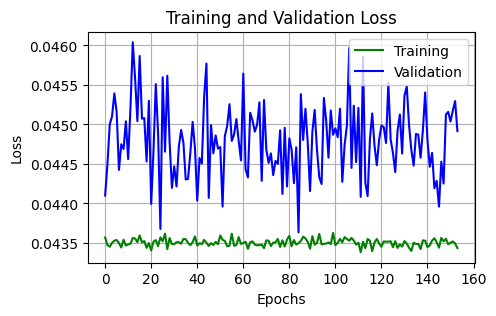

Final Training Loss:   0.043589
Final Validation Loss: 0.015174


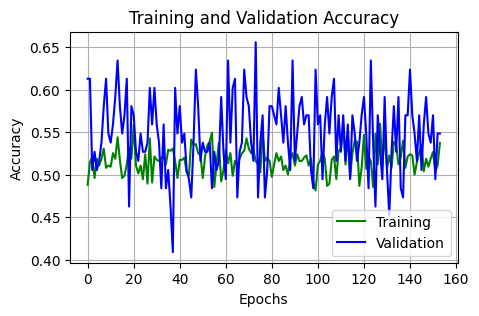

Final Training Accuracy:   0.472
Final Validation Accuracy: 0.408602

Test Accuracy: 0.3958



In [18]:
num_correct_test = 0
evalModel = model
evalModel.load_state_dict(torch.load(WEIGHTS_PATH))
evalModel.eval()

test_loss = 0
test_correct = 0

for idx, batch in enumerate(iter(test_iter)):
  predictions = model(batch.sentence.to(device))
  labels = F.one_hot(batch.label, num_classes=2).float().to(device)
  test_loss = criterion(predictions, labels)

  correct = (torch.argmax(predictions, dim=1) == torch.argmax(labels, dim=1))

  test_correct += correct.sum()
  test_loss += loss.item()

  val_losses[epoch]   = test_loss/N_val
  val_accuracy[epoch] = test_correct/N_val

test_accuracy = test_correct / N_test

show_performance_curves(training_losses,val_losses,training_accuracy,val_accuracy,test_accuracy,last_epoch)